#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import pandas as pd
from pymorphy2 import MorphAnalyzer
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_distances

In [153]:
# в нашем корпусе 20к текстов
# wiki = open('wiki_data.txt', encoding="UTF-8").read().split('\n')

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)  
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [154]:
# !pip install spacy

In [155]:
# !spacy download ru_core_news_sm

In [2]:
morph = MorphAnalyzer()

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

def preprocess_lemm(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word]
    return tokens

In [3]:
vocab = Counter()
wiki = open('wiki_data.txt', encoding='utf-8-sig')

In [6]:
preprocessed_texts = []

for text in tqdm(wiki):
    preprocessed_texts.append(preprocess_lemm(text))

20002it [01:56, 172.29it/s]


In [7]:
with open('preprocessed_texts.pickle', 'wb') as f:
    pickle.dump(preprocessed_texts, f)

In [8]:
preprocessed_texts = pd.read_pickle('preprocessed_texts.pickle')

In [9]:
for text in preprocessed_texts:
    vocab.update(text)

In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
len(filtered_vocab)

12065

In [12]:
word2id = { 'PAD':0}
word2id_copy = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    word2id_copy[word] = len(word2id_copy)

In [13]:
id2word = {i:word for word, i in word2id.items()}
id2word_copy = {i:word for word, i in word2id.items()}

In [14]:
vocab_size = len(id2word)

In [15]:
sentences = []
for text in preprocessed_texts:
    ids = [word2id[token] for token in text if token in word2id]
    sentences.append(ids)

In [16]:
sum_occurences = sum(vocab[i] for i in filtered_vocab)
word_probs = [vocab[word] / sum_occurences for word in filtered_vocab] # вероятности для выбора негативных примеров

### Необходимые функции


In [17]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [23]:
# skip gram
# измените размер окна на 6 для cbow и 12 для skip gram
# (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)

# чтобы получить размер окна = #слов слева + #слов справа = 6 + 6 = 12
def gen_batches_sg(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    # измените часть с np.random.randint(vocab_size) так,
                    # чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов
                    # (частотные должны выбираться реже, а редкие чаще)
                    X_context.append(word2id[np.random.choice(list(filtered_vocab), p=word_probs)])
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [35]:
# # cbow 
# измените размер окна на 6 для cbow и 12 для skip gram
# (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)

# чтобы получить размер окна = #слов слева + #слов справа = 3 + 3 = 6
def gen_batches_cbow(sentences, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                # измените часть с np.random.randint(vocab_size) так,
                # чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов
                # (частотные должны выбираться реже, а редкие чаще)
                X_target.append(word2id[np.random.choice(list(filtered_vocab), p=word_probs)])
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

### skip-gram negative sampling

In [25]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))
embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )
target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)
model_sg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_sg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model_sg.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=100,
          validation_steps=30,
          epochs=2)

Epoch 1/2
 42/100 [===========>..................] - ETA: 1:27 - loss: 0.6928 - accuracy: 0.5240

KeyboardInterrupt: 

In [28]:
embeddings_sg = model_sg.layers[2].get_weights()[0]

### cbow negative sampling

In [36]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))
embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )
target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)
model_cbow = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_cbow.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
a = gen_batches_sg(sentences[:19000], window=5)

In [39]:
model_cbow.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
  16/5000 [..............................] - ETA: 2:06:08 - loss: 0.6929 - accuracy: 0.5103

KeyboardInterrupt: 

In [182]:
embeddings_cbow = model_cbow.layers[2].get_weights()[0]

#### Сравнение

In [196]:
most_similar('соревнование', embeddings_sg)

['соревнование',
 'мир',
 'раунд',
 'квалификация',
 'чемпион',
 'победитель',
 'спортсмен',
 'чемпионат',
 'очко',
 'турнир']

In [192]:
most_similar('письмо', embeddings_sg)

['письмо',
 'чей',
 'эволюция',
 'понравиться',
 'сомнение',
 'средневековый',
 'уделять',
 'суровый',
 'обстоятельство',
 'опасаться']

In [197]:
most_similar('соревнование', embeddings_cbow)

['соревнование',
 'турнир',
 'чемпионат',
 'прыжок',
 'гонка',
 'спортсмен',
 'олимпиада',
 'квалификация',
 'финал',
 'победитель']

In [194]:
most_similar('письмо', embeddings_cbow)

['письмо',
 'текст',
 'акт',
 'брак',
 'написать',
 'представление',
 'предложение',
 'рассказ',
 'статья',
 'писать']

Обе модели выдают действительно похожие слова, но можно заметить, что cbow делает это лучше и имеет показатель больший показатель val_accuracy.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [42]:
import gensim

/Users/mnefedov/.pyenv/versions/3.7.2/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [43]:
%%time
w2v = gensim.models.Word2Vec(preprocessed_texts, 
                             vector_size=100, 
                             min_count=20, 
                             max_vocab_size=12000,
                             window=6,
                             epochs=10,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             ns_exponent=0.8,
                             cbow_mean=1)

CPU times: user 39.3 s, sys: 367 ms, total: 39.7 s
Wall time: 14.2 s


In [44]:
w2v.wv.most_similar('церковь')

[('храм', 0.8131992816925049),
 ('часовня', 0.8120839595794678),
 ('пресвятой', 0.7881289720535278),
 ('богородица', 0.7573246359825134),
 ('православный', 0.7511273622512817),
 ('собор', 0.7471047043800354),
 ('освятить', 0.7413464188575745),
 ('святитель', 0.7344061136245728),
 ('церковный', 0.7327033281326294),
 ('настоятель', 0.7156883478164673)]

### FastText

In [45]:
%%time
ft = gensim.models.FastText(preprocessed_texts, 
                             vector_size=100, 
                             min_count=20, 
                             max_vocab_size=12000,
                             window=6,
                             epochs=10,
                             hs=0,
                             negative=10,
                             sample=1e-4,
                             ns_exponent=0.8,
                             cbow_mean=1,
                             min_n=3,
                             max_n=9)

CPU times: user 3min 48s, sys: 744 ms, total: 3min 49s
Wall time: 1min 18s


In [46]:
ft.wv.most_similar('церковь')

[('храм', 0.855476975440979),
 ('часовня', 0.811062216758728),
 ('церковный', 0.7794473171234131),
 ('монастырь', 0.7752026915550232),
 ('пресвятой', 0.7730910181999207),
 ('икона', 0.7683797478675842),
 ('собор', 0.7536484599113464),
 ('монастырский', 0.7510785460472107),
 ('святитель', 0.749880313873291),
 ('богородица', 0.748834490776062)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

Использовалась модель: news_upos_skipgram_300_5_2019

In [224]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [225]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.6986004710197449),
 ('апрель_NOUN', 0.6406055688858032),
 ('январь_NOUN', 0.6310263276100159),
 ('гребцов::и::сасим_PROPN', 0.5914050936698914),
 ('декабрь_NOUN', 0.5900784134864807),
 ('парламентинский_ADJ', 0.5845531821250916),
 ('май_NOUN', 0.5792794823646545),
 ('июль_NOUN', 0.5510830879211426),
 ('октябрь_NOUN', 0.5452835559844971),
 ('ноябрь_NOUN', 0.5448249578475952)]

In [226]:
mapping = {}

for line in open('ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [283]:
from pymystem3 import Mystem
m = Mystem()

In [284]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [229]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess_lemm)

In [230]:
data.head()

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0,"[верблюд-то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\r\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч..."


In [233]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6308

In [234]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [235]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [236]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [237]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Необходимые функции

In [210]:
def get_matrix(ft):
    weights = np.zeros((len(word2id), 100))
    for word, i in word2id.items():
        # вектор паддинга оставим нулевым
        if word == 'PAD':
            continue
        try:
            weights[i] = ft.wv[word]
        except KeyError:
            # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
            continue
            weights[i] = ft.wv['опрагпллирао']
    return weights


def get_matrix_tf(ft):
    weights = np.zeros((len(word2id), 100))
    for word, i in tqdm(word2id.items()):
        # вектор паддинга оставим нулевым
        if word == 'PAD':
            continue
        try:
            vec = ft.layers[2].get_weights()[0][word2id_copy[word]]
            weights[i] = vec
#             weights[i] = ft.wv[word]
        except KeyError:
            # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
            continue
            weights[i] = ft.layers[2].get_weights()[0][word2id_copy['опрагпллирао']]
#             weights[i] = ft.wv['опрагпллирао']
    return weights

In [211]:
def init_model(weights):
    inputs = tf.keras.layers.Input(shape=(100,))
    embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                           trainable=False,
                                           weights=[weights])(inputs, )
    mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Gensim word2vec

In [212]:
model_w2v = init_model(get_matrix(w2v))

model_w2v.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=128,
          epochs=50)

Epoch 1/50
107/107 [==============================] - 1s 6ms/step - loss: 0.6821 - accuracy: 0.5694 - val_loss: 0.6528 - val_accuracy: 0.6449
Epoch 2/50
107/107 [==============================] - 0s 4ms/step - loss: 0.6341 - accuracy: 0.6658 - val_loss: 0.6338 - val_accuracy: 0.6449
Epoch 3/50
107/107 [==============================] - 0s 3ms/step - loss: 0.6185 - accuracy: 0.6660 - val_loss: 0.6254 - val_accuracy: 0.6449
Epoch 4/50
107/107 [==============================] - 0s 4ms/step - loss: 0.6094 - accuracy: 0.6661 - val_loss: 0.6184 - val_accuracy: 0.6449
Epoch 5/50
107/107 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.6661 - val_loss: 0.6123 - val_accuracy: 0.6449
Epoch 6/50
107/107 [==============================] - 0s 3ms/step - loss: 0.5954 - accuracy: 0.6662 - val_loss: 0.6065 - val_accuracy: 0.6449
Epoch 7/50
107/107 [==============================] - 0s 3ms/step - loss: 0.5895 - accuracy: 0.6663 - val_loss: 0.6016 - val_accuracy: 0.6463
Epoch 

### Gensim fasttext

In [213]:
model_ft = init_model(get_matrix(w2v))

model_ft.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
428/428 [==============================] - 2s 3ms/step - loss: 0.6339 - accuracy: 0.6585 - val_loss: 0.6256 - val_accuracy: 0.6449
Epoch 2/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6026 - accuracy: 0.6655 - val_loss: 0.6063 - val_accuracy: 0.6449
Epoch 3/50
428/428 [==============================] - 1s 2ms/step - loss: 0.5854 - accuracy: 0.6667 - val_loss: 0.5938 - val_accuracy: 0.6477
Epoch 4/50
428/428 [==============================] - 1s 2ms/step - loss: 0.5729 - accuracy: 0.6688 - val_loss: 0.5841 - val_accuracy: 0.6602
Epoch 5/50
428/428 [==============================] - 1s 2ms/step - loss: 0.5634 - accuracy: 0.6764 - val_loss: 0.5773 - val_accuracy: 0.6588
Epoch 6/50
428/428 [==============================] - 1s 2ms/step - loss: 0.5559 - accuracy: 0.6851 - val_loss: 0.5722 - val_accuracy: 0.6644
Epoch 7/50
428/428 [==============================] - 1s 2ms/step - loss: 0.5497 - accuracy: 0.6910 - val_loss: 0.5687 - val_accuracy: 0.6713
Epoch 

### Tensorflow skip-gram

In [214]:
model_tf_sg = init_model(get_matrix_tf(model_sg))

model_tf_sg.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

100%|██████████| 6309/6309 [00:35<00:00, 178.55it/s]


Epoch 1/50
428/428 [==============================] - 2s 3ms/step - loss: 0.6513 - accuracy: 0.6571 - val_loss: 0.6341 - val_accuracy: 0.6463
Epoch 2/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6187 - accuracy: 0.6661 - val_loss: 0.6265 - val_accuracy: 0.6463
Epoch 3/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6131 - accuracy: 0.6661 - val_loss: 0.6242 - val_accuracy: 0.6463
Epoch 4/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6106 - accuracy: 0.6661 - val_loss: 0.6217 - val_accuracy: 0.6463
Epoch 5/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6086 - accuracy: 0.6661 - val_loss: 0.6198 - val_accuracy: 0.6463
Epoch 6/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6068 - accuracy: 0.6661 - val_loss: 0.6180 - val_accuracy: 0.6463
Epoch 7/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6052 - accuracy: 0.6661 - val_loss: 0.6161 - val_accuracy: 0.6463
Epoch 

### Tensorflow cbow

In [220]:
model_tf_cbow = init_model(get_matrix_tf(model_cbow))

model_tf_cbow.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

100%|██████████| 6309/6309 [00:34<00:00, 180.30it/s]


Epoch 1/50
428/428 [==============================] - 2s 2ms/step - loss: 0.6378 - accuracy: 0.6661 - val_loss: 0.6324 - val_accuracy: 0.6463
Epoch 2/50
428/428 [==============================] - 1s 3ms/step - loss: 0.6163 - accuracy: 0.6661 - val_loss: 0.6303 - val_accuracy: 0.6463
Epoch 3/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6132 - accuracy: 0.6661 - val_loss: 0.6277 - val_accuracy: 0.6463
Epoch 4/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6105 - accuracy: 0.6661 - val_loss: 0.6251 - val_accuracy: 0.6463
Epoch 5/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6079 - accuracy: 0.6661 - val_loss: 0.6221 - val_accuracy: 0.6463
Epoch 6/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6053 - accuracy: 0.6660 - val_loss: 0.6198 - val_accuracy: 0.6463
Epoch 7/50
428/428 [==============================] - 1s 2ms/step - loss: 0.6028 - accuracy: 0.6661 - val_loss: 0.6170 - val_accuracy: 0.6477
Epoch 

### RusVectors

In [269]:
from gensim.models import KeyedVectors

model_ = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [286]:
weights = np.zeros((len(word2id), 300))

for word, i in tqdm(word2id.items()):
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = model_[normalize_mystem(word)[0]]
#         weights[i] = model_[preprocess_lemm(word)]
    except KeyError:
        continue
        weights[i] = model_.wv['опрагпллирао']
    except IndexError:
        continue

100%|██████████| 6309/6309 [2:39:11<00:00,  1.51s/it]  


In [287]:
inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [288]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [289]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
428/428 [==============================] - 3s 5ms/step - loss: 0.6477 - accuracy: 0.6644 - val_loss: 0.6172 - val_accuracy: 0.6796
Epoch 2/50
428/428 [==============================] - 2s 4ms/step - loss: 0.6176 - accuracy: 0.6644 - val_loss: 0.6036 - val_accuracy: 0.6796
Epoch 3/50
428/428 [==============================] - 2s 4ms/step - loss: 0.6102 - accuracy: 0.6644 - val_loss: 0.5968 - val_accuracy: 0.6796
Epoch 4/50
428/428 [==============================] - 2s 4ms/step - loss: 0.6048 - accuracy: 0.6644 - val_loss: 0.5914 - val_accuracy: 0.6796
Epoch 5/50
428/428 [==============================] - 2s 4ms/step - loss: 0.5999 - accuracy: 0.6644 - val_loss: 0.5867 - val_accuracy: 0.6796
Epoch 6/50
428/428 [==============================] - 2s 4ms/step - loss: 0.5951 - accuracy: 0.6644 - val_loss: 0.5820 - val_accuracy: 0.6796
Epoch 7/50
428/428 [==============================] - 2s 4ms/step - loss: 0.5906 - accuracy: 0.6644 - val_loss: 0.5777 - val_accuracy: 0.6796
Epoch 

### Результаты:

In [274]:
def get_res(model):
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() 

#### Gensim word2vec

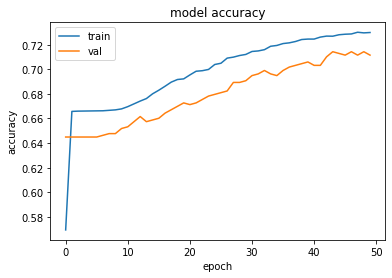

In [275]:
get_res(model_w2v)

#### Gensim fasttext

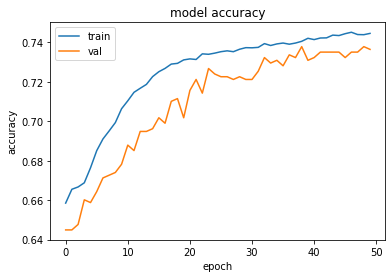

In [276]:
get_res(model_ft)

#### Tensorflow skip-gram

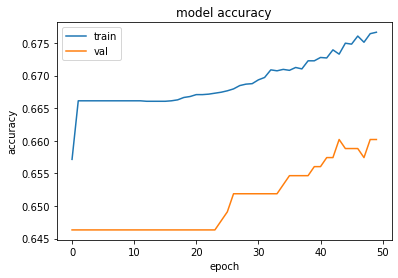

In [280]:
get_res(model_tf_sg)

#### Tensorflow cbow

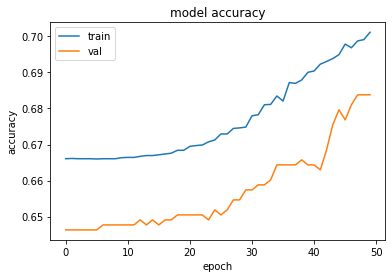

In [279]:
get_res(model_tf_cbow)

#### RusVectors

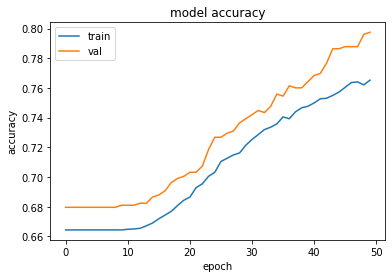

In [290]:
get_res(model)

В итоге можно наблюдать, что tensorflow модели показывают наименьший результат, потом идут модели gensim (tensorflow skip-gram ~ tensorflow cbow < w2v ~ fasttext), но лучший результат всё-таки показывает RusVectors (news_upos_skipgram_300_5_2019)